# imports & notebooks

In [90]:
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import interp1d
import os
import glob
import sys
import h5py

In [91]:
path = os.getcwd()
if path[1:5] == "Home":
    %run /Home/siv30/wad005/master/GRB/src/convert_erg.ipynb #UiB paths
else:
    %run /Users/andreas/phys/master/GRB/src/convert_erg.ipynb # Mac paths

All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!


# Extracting bg data for GRB190206A
    doy: 37
    trigtime: 2019-02-06  03:49:28.230

### Importing matlab file

In [188]:
#matlab script for converting datetime objects to strings
"""fname = 'all_bgo_calibration_data_OBBA_2018_239_only.mat'
data = load(fname);
datetimes = data.out_data_tmp.times;
regular_times = string(datetimes);
data.out_data_tmp.times = cellstr(regular_times);
output = data.out_data_tmp;"""

"fname = 'all_bgo_calibration_data_OBBA_2018_239_only.mat'\ndata = load(fname);\ndatetimes = data.out_data_tmp.times;\nregular_times = string(datetimes);\ndata.out_data_tmp.times = cellstr(regular_times);\noutput = data.out_data_tmp;"

In [3]:
data_path = '/Users/andreas/phys/master/hed_bgo_acc_background_for_grb/data/' #'/Home/siv30/wad005/master/hed_bgo_acc_background_for_grb/data/'
fname = 'output.mat' #HDF5 format>>use scipy.io
#fname = 'all_bgo_calibration_data_OBBA_2019_37_only.mat'
#f = h5py.File(fname,'r')
f = scipy.io.loadmat(fname,appendmat=False, simplify_cells=True) #not working for mat73 files
#data = f['out_data_tmp'].get('times')

In [4]:
#problem: The string containing the datetime is converted to matlabOpaque
#solution: convert datetimes to cellstr array>> loading works fine

In [5]:
f.keys()

dict_keys(['__header__', '__version__', '__globals__', 'output'])

In [6]:
d = f['output']
times = np.array(d['times'],dtype=str)
dau_1_det_1 = d['spec_bgo_dau_1_ch_1'] #uint16

In [7]:
times.shape,dau_1_det_1.shape #cols in dau_det is for the selected time interval

((262,), (1024, 262))

In [8]:
# T0 =  2019-02-06  03:49:28.230 
times[27:30]
#selecting col 29 for bkg estimation

array(['2019-Feb-06 03:19:17.961773', '2019-Feb-06 03:25:36.962156',
       '2019-Feb-06 03:30:38.982460'], dtype='<U27')

In [9]:
counts_chan = dau_1_det_1[:,27] #27th column
print(len(counts_chan)) #ok!

1024


In [10]:
T0_start = datetime.strptime(times[27],'%Y-%b-%d %H:%M:%S.%f')
T0_end = datetime.strptime(times[30],'%Y-%b-%d %H:%M:%S.%f')
exposure = (T0_end-T0_start).total_seconds()
print(exposure,'[s] ~30 min before burst')

1572.01857 [s] ~30 min before burst


# Calibration coefs

In [11]:
coefs = get_coefs(T0_start)
coefs['dau_1_det_1']

{'a': 0.004946, 'b': 8.3696, 'c': 53.79335}

# Notes
    -Already have the data in spectrum; meaning counts per energy channel. Channel ranging from 1-1024 (compressed from 4096).
    So the channels have been grouped by 4. 
    
    - Have to find the calibration coefs (a,b,c) and compute the 2. degree approx. of the keV bin.
    
    - Guessing one have to limit the bins from 10keV- 10MeV
    
    - Then interpolate the counts in each bin to get a Pn(x) of n-th degree, and then compute the background estimation for all
    the bins.
    ---------------------------------------------------------------
    -TODO: Group the bins by the bins used in xspec_bins (log)
    
    - Proper bkg estimation
        >> HED: 4 DAUs (Detector Assembly Units) and three channels for each DAU. One channel consists of one BGO crystal and one PMT.
        >> Need to sum up all the counts from all the DAUs and channels into one joint array to get a proper estimate of the background.
        >> Important to sum up along the energy channels --> create a matrix / df to do this
        
        Get an estimate for counts per second from this data & the bkg spectrum I have from keV_hist function
        
    

# spectrum plot

In [12]:
np.all(counts_chan==0) #zeros... ?
#Have to use col=27 >> first non-zero col before burst

False

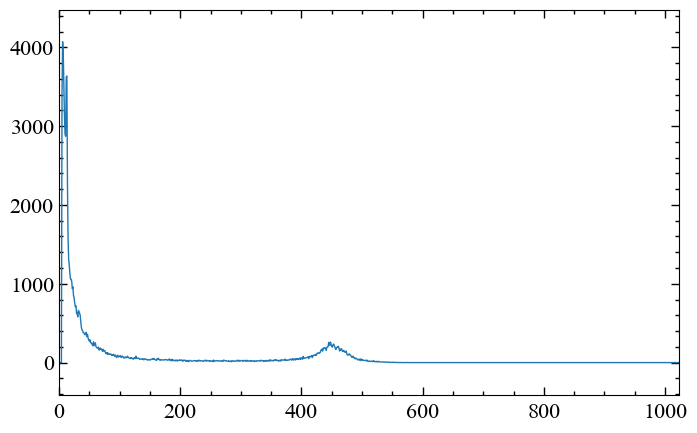

In [15]:
%matplotlib inline
plt.plot(counts_chan)

In [83]:
bins = np.arange(1,1025)
#bins = (bins**2)*coefs['dau_1_det_1']['a'] + bins*coefs['dau_1_det_1']['b'] + coefs['dau_1_det_1']['c']

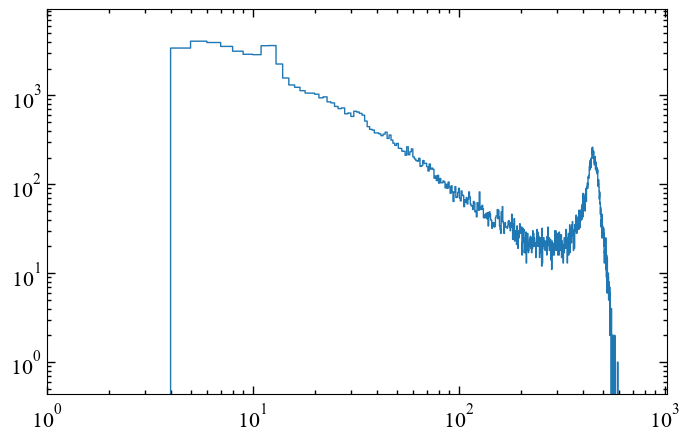

In [89]:
plt.step(x=bins_new[:-1],y=counts_chan,where='pre')
plt.yscale('log')
plt.xscale('log')
#plt.xlim(left=0,right=150)
#plt.ylim(bottom=0,top=10)

In [85]:
bins_new = np.insert(bins,0,values=0)

In [82]:
bins_new[:11]

array([  0.      ,  62.167896,  70.552334,  78.946664,  87.350886,
        95.765   , 104.189006, 112.622904, 121.066694, 129.520376,
       137.98395 ])

In [77]:
counts_chan[:11]

array([   5,    0,    0,    0,    0, 3408, 4071, 3934, 3556, 3141, 2900],
      dtype=uint16)

# Remake of spectrum plot
    -just to make sure Im importing and plotting correctly

In [100]:
T0_example = '2018-Aug-27 20:02:53.586117' 
# DAU_1_CH_1
# DOY = 239

In [95]:
#data_path = '/Users/andreas/phys/master/hed_bgo_acc_background_for_grb/data/' #'/Home/siv30/wad005/master/hed_bgo_acc_background_for_grb/data/'
fname = 'output_180827.mat' #HDF5 format>>use scipy.io
f = scipy.io.loadmat(fname,appendmat=False, simplify_cells=True) #not working for mat73 files
f.keys()

dict_keys(['__header__', '__version__', '__globals__', 'output'])

In [109]:
times_example = f['output']['times']
if T0_example in times_example:
    i = list(times_example).index(T0_example)
    print(i)
times_example[i]

199


'2018-Aug-27 20:02:53.586117'

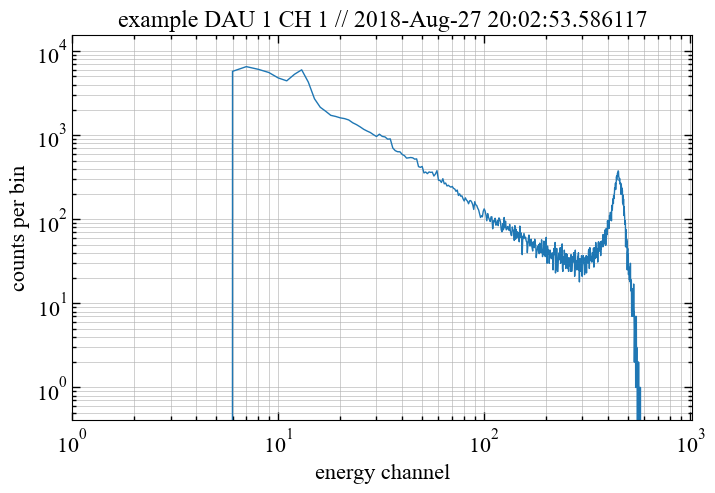

In [126]:
dau_1_det_1_counts = f['output']['spec_bgo_dau_1_ch_1'][:,i]
plt.plot(np.arange(1,1025),dau_1_det_1_counts)
plt.yscale('log')
plt.xscale('log')
plt.grid(which="both")
plt.xlabel('energy channel')
plt.ylabel('counts per bin')
plt.title('example DAU 1 CH 1 // ' + T0_example)
plt.show()

# Function for importing all DAU's and CH's

In [143]:
def import_all(fname=None, time_index=None):
    '''fname <str>: full filename (indluding .mat extention) for the matlab file
    time_index <int>: index for extracting spectra. This must be checked beforehand
    return <df>: DataFrame with [energy_channel, DAU_n_CH_n] matrix.'''
    f = scipy.io.loadmat(fname,appendmat=False, simplify_cells=True)
    
    dau_1_det_1_counts = np.array(f['output']['spec_bgo_dau_1_ch_1'][:,time_index])
    dau_1_det_2_counts = np.array(f['output']['spec_bgo_dau_1_ch_2'][:,time_index])
    dau_1_det_3_counts = np.array(f['output']['spec_bgo_dau_1_ch_3'][:,time_index])
    dau_2_det_1_counts = np.array(f['output']['spec_bgo_dau_2_ch_1'][:,time_index])
    dau_2_det_2_counts = np.array(f['output']['spec_bgo_dau_2_ch_2'][:,time_index])
    dau_2_det_3_counts = np.array(f['output']['spec_bgo_dau_2_ch_3'][:,time_index])
    dau_3_det_1_counts = np.array(f['output']['spec_bgo_dau_3_ch_1'][:,time_index])
    dau_3_det_2_counts = np.array(f['output']['spec_bgo_dau_3_ch_2'][:,time_index])
    dau_3_det_3_counts = np.array(f['output']['spec_bgo_dau_3_ch_3'][:,time_index])
    dau_4_det_1_counts = np.array(f['output']['spec_bgo_dau_4_ch_1'][:,time_index])
    dau_4_det_2_counts = np.array(f['output']['spec_bgo_dau_4_ch_2'][:,time_index])
    dau_4_det_3_counts = np.array(f['output']['spec_bgo_dau_4_ch_3'][:,time_index])

    channels_dict = {'dau_1_det_1':dau_1_det_1_counts,'dau_1_det_2':dau_1_det_2_counts, 'dau_1_det_3': dau_1_det_3_counts,
                'dau_2_det_1':dau_2_det_1_counts,'dau_2_det_2': dau_2_det_2_counts,'dau_2_det_3': dau_2_det_3_counts,
                'dau_3_det_1':dau_3_det_1_counts,'dau_3_det_2':dau_3_det_2_counts,'dau_3_det_3':dau_3_det_3_counts,
                'dau_4_det_1':dau_4_det_1_counts,'dau_4_det_2':dau_4_det_2_counts,'dau_4_det_3':dau_4_det_3_counts}
    df = pd.DataFrame(channels_dict)
    df['total'] = df.sum(axis=1)
    return df
    

In [144]:
df = import_all(fname=fname,time_index=199)

In [145]:
df

,dau_1_det_1,dau_1_det_2,dau_1_det_3,dau_2_det_1,dau_2_det_2,dau_2_det_3,dau_3_det_1,dau_3_det_2,dau_3_det_3,dau_4_det_1,dau_4_det_2,dau_4_det_3,total
0,2,0,6,4,4,0,13,5,9,4,6,1,54
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,12230,14957,10503,0,0,0,37690
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,0,0,0,0,0,0,0,0,0,0,0,0,0
1020,0,0,0,0,0,0,0,0,0,0,0,0,0
1021,0,0,0,0,0,0,0,0,0,0,0,0,0
1022,0,0,0,0,0,0,0,0,0,0,0,0,0


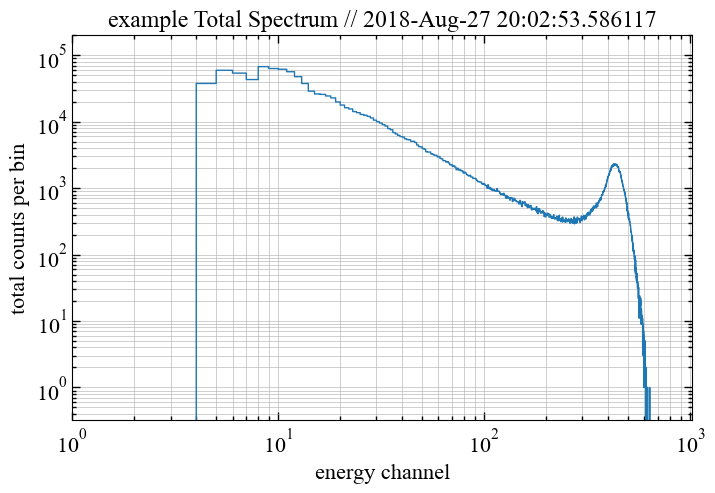

In [146]:
plt.step(x=np.arange(1,1025),y=df['total'])
plt.yscale('log')
plt.xscale('log')
plt.grid(which="both")
plt.xlabel('energy channel')
plt.ylabel('total counts per bin')
plt.title('example Total Spectrum // ' + T0_example)
plt.show()

In [159]:
len(df['total'].values), len(np.arange(1,1025))

(1024, 1024)

In [185]:
np.arange(0,1025)

array([   0,    1,    2, ..., 1022, 1023, 1024])

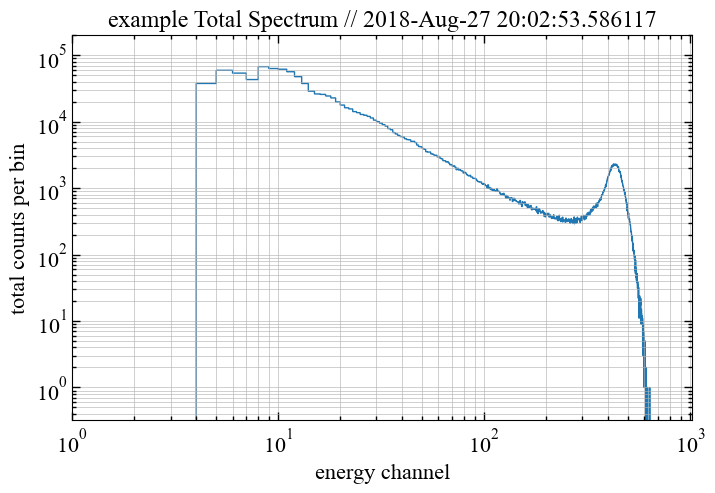

In [187]:
plt.stairs(values=df['total'].values,edges=np.arange(0,1025)) #energy channel 0-->1 % last bin: 1023-->1024
plt.yscale('log')
plt.xscale('log')
plt.grid(which="both")
plt.xlabel('energy channel')
plt.ylabel('total counts per bin')
plt.title('example Total Spectrum // ' + T0_example)
plt.show()

In [182]:
df

,dau_1_det_1,dau_1_det_2,dau_1_det_3,dau_2_det_1,dau_2_det_2,dau_2_det_3,dau_3_det_1,dau_3_det_2,dau_3_det_3,dau_4_det_1,dau_4_det_2,dau_4_det_3,total
0,2,0,6,4,4,0,13,5,9,4,6,1,54
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,12230,14957,10503,0,0,0,37690
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,0,0,0,0,0,0,0,0,0,0,0,0,0
1020,0,0,0,0,0,0,0,0,0,0,0,0,0
1021,0,0,0,0,0,0,0,0,0,0,0,0,0
1022,0,0,0,0,0,0,0,0,0,0,0,0,0
